# Procesamiento Digital de Audio
## Caleb Rascón
### Separación de Fuentes en Línea

#### LCMV - Linearly Constrained Minimun Variance

In [19]:
#Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from delay_f import delay_f 
from trianglewave import  trianglewave


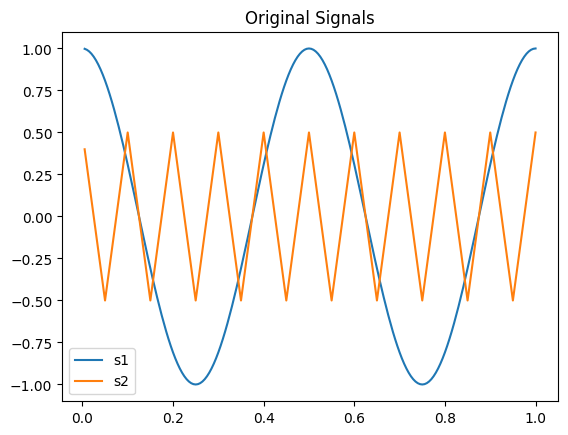

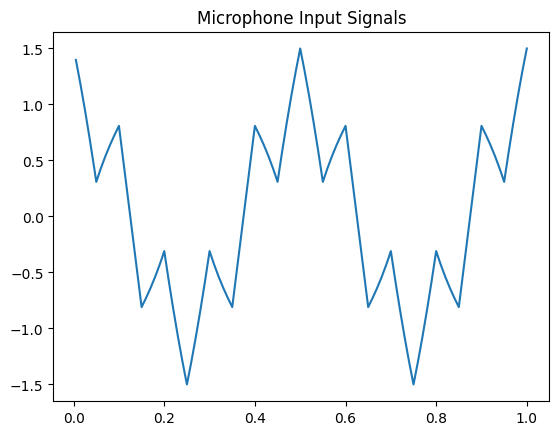

Singular matrix at frequency bin 0, using identity weights


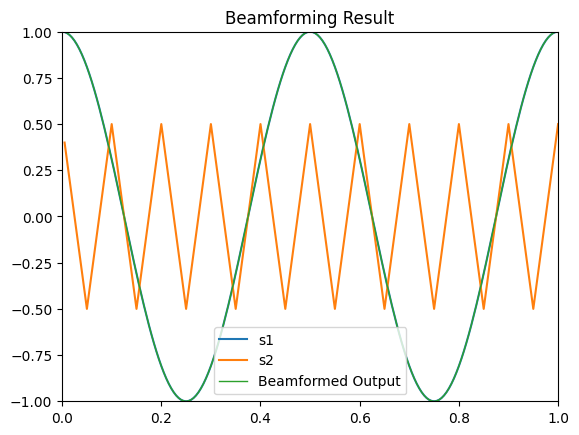

In [22]:
# Parameters
doa1 = 20 * np.pi / 180  # Direction of arrival of first signal
doa2 = -40 * np.pi / 180  # Direction of arrival of second signal
doa_steer = doa1  # Direction to steer the beamformer
doa_null = doa2  # Direction to nullify interference
d = 4  # Distance between microphones in meters (original: 4)
M = 8  # Number of microphones (original: 8)
amp_out = 1  # Post-amplification for beamformer output
N = 200  # Signal size in samples

# Simulating signals
t = np.arange(1, N + 1) / N  # Time vector (1 second)
c = 343  # Speed of sound
fs = N  # Sampling frequency same as signal size (1 second)

# Original signals
s1 = np.cos(2 * np.pi * 2 * t)
s2 = trianglewave(10, N) * 0.5

plt.figure()
plt.plot(t, s1, label="s1")
plt.plot(t, s2, label="s2")
plt.legend()
plt.title('Original Signals')
plt.show()

# Microphones (input signals)
X = np.zeros((M, N))
X[0, :] = s1 + s2
for m in range(1, M):
    X[m, :] = delay_f(s1, (m * d / c) * np.sin(doa1), fs) + delay_f(s2, (m * d / c) * np.sin(doa2), fs)

plt.figure()
plt.plot(t, X[0, :])
plt.title('Microphone Input Signals')
plt.show()

# Calculating the base steering vector
w_c = np.zeros((M, N), dtype=complex)
w_b = np.zeros((M, N), dtype=complex)
w = np.concatenate(([0], np.arange(1, N//2+1), np.arange(-N//2+1, 0))) / N * fs
w_c[0, :] = np.ones(N)
w_b[0, :] = np.ones(N)
for m in range(1, M):
    for f in range(N):
        w_c[m, f] = np.exp(-1j * (2 * np.pi * w[f] * m * d / c) * np.sin(doa_steer))
        w_b[m, f] = np.exp(-1j * (2 * np.pi * w[f] * m * d / c) * np.sin(doa_null))

# FFT
X = np.fft.fft(X, axis=1)

# Applying beamformer
o_f = np.zeros(N, dtype=complex)
for f in range(N):
    R = np.outer(X[:, f], X[:, f].conj())  # Covariance matrix
    
    # Diagonal loading to make R invertible
    R += np.eye(M) * 0.01 * np.trace(R)  # Adjust the regularization factor if needed
    # print(f'{f=}, {np.linalg.det(R)=}')
    inv_R = np.linalg.pinv(R)  # Pseudo-inverse for robustness

    w_a = np.column_stack((w_c[:, f], w_b[:, f]))

    # Calculating the optimal beamformer weights
    try:
        w_o = np.dot(inv_R, w_a) @ np.linalg.inv(np.dot(w_a.T.conj(), inv_R) @ w_a)
    except np.linalg.LinAlgError:
        print(f"Singular matrix at frequency bin {f}, using identity weights")
        w_o = np.eye(w_a.shape[0], w_a.shape[1])
        
    o_f[f] = np.dot(w_o[:, 0].conj().T, X[:, f])

o = np.real(np.fft.ifft(o_f))
o = o * amp_out

plt.figure()
plt.plot(t, s1, label='s1')
plt.plot(t, s2, label='s2')
plt.plot(t, o, linewidth=1, label='Beamformed Output')
plt.axis([0, 1, -1, 1])
plt.legend()
plt.title('Beamforming Result')
plt.show()
